In [1]:
#https://tedboy.github.io/nlps/generated/generated/gensim.models.LdaModel.html

In [2]:
from IPython.display import HTML
css_str = '<style> \
.jp-Button path { fill: #616161;} \
text.terms { fill: #616161;} \
.jp-icon-warn0 path {fill: var(--jp-warn-color0);} \
.bp3-button-text path { fill: var(--jp-inverse-layout-color3);} \
.jp-icon-brand0 path { fill: var(--jp-brand-color0);} \
text.terms { fill: #616161;} \
</style>'
display(HTML(css_str ))

In [3]:
#Import packages
import numpy as np
import pandas as pd
import re
from pprint import pprint
from numpy import random

#Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

#Text-preprocessing (lemmatization) from spacy
import spacy

#Visualization tools
import pyLDAvis
import pyLDAvis.gensim_models
import matplotlib.pyplot as plt

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

/usr/local/lib/python3.7/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload


In [4]:
#Stopwords from NLTK
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

In [5]:
#Import data 'Newsgroup'
df = pd.read_json('https://raw.githubusercontent.com/selva86/datasets/master/newsgroups.json')
print(df.target_names.unique())
df.head()

['rec.autos' 'comp.sys.mac.hardware' 'comp.graphics' 'sci.space'
 'talk.politics.guns' 'sci.med' 'comp.sys.ibm.pc.hardware'
 'comp.os.ms-windows.misc' 'rec.motorcycles' 'talk.religion.misc'
 'misc.forsale' 'alt.atheism' 'sci.electronics' 'comp.windows.x'
 'rec.sport.hockey' 'rec.sport.baseball' 'soc.religion.christian'
 'talk.politics.mideast' 'talk.politics.misc' 'sci.crypt']


,content,target,target_names
0,From: lerxst@wam.umd.edu (where's my thing)\nS...,7,rec.autos
1,From: guykuo@carson.u.washington.edu (Guy Kuo)...,4,comp.sys.mac.hardware
2,From: twillis@ec.ecn.purdue.edu (Thomas E Will...,4,comp.sys.mac.hardware
3,From: jgreen@amber (Joe Green)\nSubject: Re: W...,1,comp.graphics
4,From: jcm@head-cfa.harvard.edu (Jonathan McDow...,14,sci.space


In [6]:
#Convert to list and remove emails, newline, single quotes
data = df.content.values.tolist()
data = [re.sub('\S*@\S*\s?', '', sent) for sent in data]
data = [re.sub('\s+', ' ', sent) for sent in data]
data = [re.sub("\'", "", sent) for sent in data]
print(data[:1])

['From: (wheres my thing) Subject: WHAT car is this!? Nntp-Posting-Host: rac3.wam.umd.edu Organization: University of Maryland, College Park Lines: 15 I was wondering if anyone out there could enlighten me on this car I saw the other day. It was a 2-door sports car, looked to be from the late 60s/ early 70s. It was called a Bricklin. The doors were really small. In addition, the front bumper was separate from the rest of the body. This is all I know. If anyone can tellme a model name, engine specs, years of production, where this car is made, history, or whatever info you have on this funky looking car, please e-mail. Thanks, - IL ---- brought to you by your neighborhood Lerxst ---- ']


In [7]:
#Tokenize words by gensim's simple_preprocess()
def tokenization(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))

data_words = list(tokenization(data))
print(data_words[:1])

[['from', 'wheres', 'my', 'thing', 'subject', 'what', 'car', 'is', 'this', 'nntp', 'posting', 'host', 'rac', 'wam', 'umd', 'edu', 'organization', 'university', 'of', 'maryland', 'college', 'park', 'lines', 'was', 'wondering', 'if', 'anyone', 'out', 'there', 'could', 'enlighten', 'me', 'on', 'this', 'car', 'saw', 'the', 'other', 'day', 'it', 'was', 'door', 'sports', 'car', 'looked', 'to', 'be', 'from', 'the', 'late', 'early', 'it', 'was', 'called', 'bricklin', 'the', 'doors', 'were', 'really', 'small', 'in', 'addition', 'the', 'front', 'bumper', 'was', 'separate', 'from', 'the', 'rest', 'of', 'the', 'body', 'this', 'is', 'all', 'know', 'if', 'anyone', 'can', 'tellme', 'model', 'name', 'engine', 'specs', 'years', 'of', 'production', 'where', 'this', 'car', 'is', 'made', 'history', 'or', 'whatever', 'info', 'you', 'have', 'on', 'this', 'funky', 'looking', 'car', 'please', 'mail', 'thanks', 'il', 'brought', 'to', 'you', 'by', 'your', 'neighborhood', 'lerxst']]


In [8]:
#Remove stopwords by spacy
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

data_words_nostops = remove_stopwords(data_words)
print(data_words_nostops[:1])

[['wheres', 'thing', 'car', 'nntp', 'posting', 'host', 'rac', 'wam', 'umd', 'organization', 'university', 'maryland', 'college', 'park', 'lines', 'wondering', 'anyone', 'could', 'enlighten', 'car', 'saw', 'day', 'door', 'sports', 'car', 'looked', 'late', 'early', 'called', 'bricklin', 'doors', 'really', 'small', 'addition', 'front', 'bumper', 'separate', 'rest', 'body', 'know', 'anyone', 'tellme', 'model', 'name', 'engine', 'specs', 'years', 'production', 'car', 'made', 'history', 'whatever', 'info', 'funky', 'looking', 'car', 'please', 'mail', 'thanks', 'il', 'brought', 'neighborhood', 'lerxst']]


In [9]:
#Create Bigram by gensim's Phrases()
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) 
bigram_mod = gensim.models.phrases.Phraser(bigram)

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

data_words_bigrams = make_bigrams(data_words_nostops)
print(data_words_bigrams[:1])

[['wheres', 'thing', 'car', 'nntp_posting', 'host', 'rac_wam', 'umd', 'organization', 'university', 'maryland_college', 'park', 'lines', 'wondering', 'anyone', 'could', 'enlighten', 'car', 'saw', 'day', 'door', 'sports', 'car', 'looked', 'late', 'early', 'called', 'bricklin', 'doors', 'really', 'small', 'addition', 'front_bumper', 'separate', 'rest', 'body', 'know', 'anyone', 'tellme', 'model', 'name', 'engine', 'specs', 'years', 'production', 'car', 'made', 'history', 'whatever', 'info', 'funky', 'looking', 'car', 'please', 'mail', 'thanks', 'il', 'brought', 'neighborhood', 'lerxst']]


In [10]:
#Lemmatization by spacy's en_core_web_sm, only keep noun, adj, vb, adv
def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

nlp = spacy.load("en_core_web_sm")
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])
print(data_lemmatized[:1])

[['s', 'thing', 'car', 'nntp_poste', 'host', 'umd', 'organization', 'park', 'line', 'wonder', 'enlighten', 'car', 'see', 'day', 'door', 'sport', 'car', 'look', 'late', 'early', 'call', 'bricklin', 'door', 'really', 'small', 'addition', 'separate', 'rest', 'body', 'know', 'tellme', 'model', 'name', 'engine', 'spec', 'year', 'production', 'car', 'make', 'history', 'info', 'funky', 'look', 'car', 'mail', 'thank', 'bring', 'neighborhood', 'lerxst']]


In [11]:
#Create Dictionary (id2word), Dataset (texts), Document-Word frequency(corpus)
id2word = corpora.Dictionary(data_lemmatized)
texts = data_lemmatized
corpus = [id2word.doc2bow(text) for text in texts]

# View (Word_index, Word), Frequency
print([[((id, id2word[id]), freq) for id, freq in cp] for cp in corpus[:1]])

[[((0, 'addition'), 1), ((1, 'body'), 1), ((2, 'bricklin'), 1), ((3, 'bring'), 1), ((4, 'call'), 1), ((5, 'car'), 5), ((6, 'day'), 1), ((7, 'door'), 2), ((8, 'early'), 1), ((9, 'engine'), 1), ((10, 'enlighten'), 1), ((11, 'funky'), 1), ((12, 'history'), 1), ((13, 'host'), 1), ((14, 'info'), 1), ((15, 'know'), 1), ((16, 'late'), 1), ((17, 'lerxst'), 1), ((18, 'line'), 1), ((19, 'look'), 2), ((20, 'mail'), 1), ((21, 'make'), 1), ((22, 'model'), 1), ((23, 'name'), 1), ((24, 'neighborhood'), 1), ((25, 'nntp_poste'), 1), ((26, 'organization'), 1), ((27, 'park'), 1), ((28, 'production'), 1), ((29, 'really'), 1), ((30, 'rest'), 1), ((31, 's'), 1), ((32, 'see'), 1), ((33, 'separate'), 1), ((34, 'small'), 1), ((35, 'spec'), 1), ((36, 'sport'), 1), ((37, 'tellme'), 1), ((38, 'thank'), 1), ((39, 'thing'), 1), ((40, 'umd'), 1), ((41, 'wonder'), 1), ((42, 'year'), 1)]]


In [12]:
#Build LDA model
num_topics = 20
lda_model = gensim.models.ldamodel.LdaModel(
    corpus=corpus, id2word=id2word, num_topics=num_topics, random_state=100,
    update_every=1, chunksize=100, passes=10, alpha='auto', per_word_topics=True)

In [13]:
#Compute Perplexity - a measure of how good the model is. lower the better.
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  

#Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -13.439276927450738

Coherence Score:  0.4585698945767061


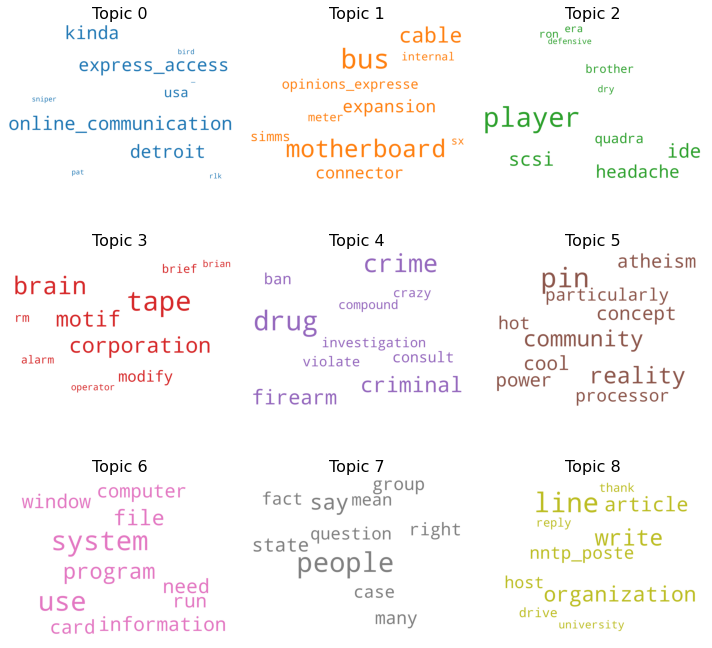

In [14]:
#Wordcloud of Top N words in each topic
#Display the N topic keywords of each topic
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop_words, background_color='white', width=2500, height=1800, max_words=10, 
                  colormap='tab10', color_func=lambda *args, **kwargs: cols[i], prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False)
fig, axes = plt.subplots(3, 3, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')

plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

In [31]:
#Display the phi distribution of topic - top words
#Print the 10 Keywords in 8 topics
for i in range(8):
    pprint(lda_model.print_topic(i, topn=10))

('0.131*"space" + 0.039*"earth" + 0.035*"launch" + 0.032*"nhl" + 0.031*"orbit" '
 '+ 0.030*"mission" + 0.029*"moon" + 0.027*"mouse" + 0.025*"satellite" + '
 '0.023*"period"')
('0.155*"player" + 0.064*"ide" + 0.063*"scsi" + 0.053*"headache" + '
 '0.030*"quadra" + 0.021*"brother" + 0.018*"ron" + 0.016*"era" + 0.013*"dry" + '
 '0.010*"defensive"')
('0.027*"system" + 0.027*"use" + 0.017*"program" + 0.016*"file" + 0.013*"need" '
 '+ 0.013*"information" + 0.012*"window" + 0.012*"run" + 0.012*"card" + '
 '0.012*"computer"')
('0.118*"line" + 0.080*"write" + 0.070*"organization" + 0.062*"article" + '
 '0.046*"nntp_poste" + 0.041*"host" + 0.023*"drive" + 0.020*"thank" + '
 '0.019*"reply" + 0.016*"university"')
('0.020*"online_communication" + 0.019*"kinda" + 0.018*"detroit" + '
 '0.018*"express_access" + 0.010*"usa" + 0.000*"_" + 0.000*"pat" + 0.000*"rlk" '
 '+ 0.000*"bird" + 0.000*"sniper"')
('0.097*"bus" + 0.077*"motherboard" + 0.057*"cable" + 0.036*"expansion" + '
 '0.033*"connector" + 0.020*

In [15]:
#Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
pyLDAvis.display(vis)

/usr/local/lib/python3.7/site-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


In [16]:
print('Number of documents: ' + str(len(corpus)))
print('Number of words: ' + str(len(id2word)))

Number of documents: 11314
Number of words: 50111


In [17]:
for i in range(5):
    print(lda_model.get_document_topics(corpus[i]))

[(2, 0.06423984), (3, 0.30467403), (11, 0.08481552), (19, 0.50648606)]
[(2, 0.123283245), (3, 0.45917934), (11, 0.09739512), (15, 0.027016068), (18, 0.014213264), (19, 0.25062278)]
[(2, 0.16244861), (3, 0.104998276), (8, 0.016312113), (11, 0.21706982), (13, 0.05711088), (19, 0.42164826)]
[(2, 0.19898064), (3, 0.26518223), (9, 0.059654407), (11, 0.081415616), (17, 0.038969148), (19, 0.3201659)]
[(0, 0.027322523), (2, 0.18449204), (3, 0.2750746), (7, 0.032812737), (9, 0.017716525), (11, 0.2142378), (12, 0.01691938), (19, 0.21351062)]


In [18]:
#Stimulate forward generating process
#Randomly pick document, get document length
document_index = random.randint(0, len(corpus)-1)
document_length = len(corpus[document_index])
print('Document Index ' + str(document_index) + ' with length ' + str(document_length))

Document Index 3710 with length 131


In [19]:
#Display the theta distribution of current document - top topics
document_topic_distribution = lda_model.get_document_topics(corpus[document_index])
number_topic_stimulate = len(document_topic_distribution)

topic_index = np.zeros(number_topic_stimulate)
multinomial_document_topic = np.zeros(number_topic_stimulate)

for j in range(number_topic_stimulate):
    topic_index[j] = document_topic_distribution[j][0]
    multinomial_document_topic[j] = document_topic_distribution[j][1]

display = {'Topic Index':topic_index, 'Distribution of Topics':multinomial_document_topic}
df = pd.DataFrame(data=display)
df

,Topic Index,Distribution of Topics
0,2.0,0.047569
1,3.0,0.102956
2,8.0,0.012287
3,10.0,0.014471
4,11.0,0.329919
5,17.0,0.010055
6,18.0,0.026706
7,19.0,0.441779


In [20]:
#Display the phi distribution of topic - top words
#Print the 10 Keywords of 5 topics
pprint(lda_model.print_topics(num_topics=5, num_words=10))

[(4,
  '0.020*"online_communication" + 0.019*"kinda" + 0.018*"detroit" + '
  '0.018*"express_access" + 0.010*"usa" + 0.000*"_" + 0.000*"pat" + '
  '0.000*"rlk" + 0.000*"bird" + 0.000*"sniper"'),
 (5,
  '0.097*"bus" + 0.077*"motherboard" + 0.057*"cable" + 0.036*"expansion" + '
  '0.033*"connector" + 0.020*"simms" + 0.020*"opinions_expresse" + '
  '0.016*"meter" + 0.014*"internal" + 0.014*"sx"'),
 (11,
  '0.024*"people" + 0.014*"say" + 0.011*"state" + 0.009*"many" + 0.009*"group" '
  '+ 0.009*"right" + 0.009*"case" + 0.009*"fact" + 0.009*"mean" + '
  '0.009*"question"'),
 (3,
  '0.118*"line" + 0.080*"write" + 0.070*"organization" + 0.062*"article" + '
  '0.046*"nntp_poste" + 0.041*"host" + 0.023*"drive" + 0.020*"thank" + '
  '0.019*"reply" + 0.016*"university"'),
 (19,
  '0.017*"go" + 0.016*"get" + 0.016*"know" + 0.015*"think" + 0.014*"good" + '
  '0.014*"time" + 0.014*"make" + 0.013*"well" + 0.013*"see" + 0.012*"say"')]


In [21]:
pprint(lda_model.print_topic(11,topn=10))

('0.024*"people" + 0.014*"say" + 0.011*"state" + 0.009*"many" + 0.009*"group" '
 '+ 0.009*"right" + 0.009*"case" + 0.009*"fact" + 0.009*"mean" + '
 '0.009*"question"')


In [22]:
#Find the value of z ~ Multinomial(theta)
from numpy import random
number_words_per_topic = random.multinomial(n=document_length, pvals=multinomial_document_topic)

display = {'Topic_Index':topic_index, 'Number of Words per Topic':number_words_per_topic}
df = pd.DataFrame(data=display)
df

,Topic_Index,Number of Words per Topic
0,2.0,5
1,3.0,7
2,8.0,2
3,10.0,1
4,11.0,51
5,17.0,1
6,18.0,3
7,19.0,61


In [26]:
#Generate the word w ~ Multinomial(phi_z)
default_top_word_count = 1000
word_generate_index = []
word_generate = []
word_generate_topic = []

for j in range(number_topic_stimulate):
    words = strs = ["" for x in range(default_top_word_count)]
    multinomial_topic_word = np.zeros(default_top_word_count)
    for k in range(default_top_word_count):
        words[k] = lda_model.show_topic(int(topic_index[j]), topn=default_top_word_count)[k][0]
        multinomial_topic_word[k] = lda_model.show_topic(int(topic_index[j]), topn=default_top_word_count)[k][1]
    
    for l in range(number_words_per_topic[j]):
        word_per_topic = random.multinomial(n=1, pvals=multinomial_topic_word)
        #print([(w, id2word[w]) for w in range(default_word_count) if (word_per_topic[w]>0)])
        for w in range(default_top_word_count):
            if (word_per_topic[w]>0):
                word_generate_index.append(w)
                word_generate.append(id2word[w])
                word_generate_topic.append(int(topic_index[j]))

In [28]:
#Display sample: distribution of words in a topic
display_sample_topic = int(random.choice(topic_index))
display = {'Words':words, 'Probability':multinomial_topic_word}
df = pd.DataFrame(data=display)
print('Topic: ' + str(display_sample_topic))
df.head(10)

Topic: 19


,Words,Probability
0,go,0.016883
1,get,0.016335
2,know,0.015995
3,think,0.014835
4,good,0.014204
5,time,0.013964
6,make,0.013706
7,well,0.013342
8,see,0.012719
9,say,0.011687


In [29]:
display = {'Word Index':word_generate_index, 'Word':word_generate, 'Topic of Word':word_generate_topic}
df = pd.DataFrame(data=display)
df

,Word Index,Word,Topic of Word
0,53,clock,2
1,3,bring,2
2,89,usage,2
3,66,hour,2
4,102,corner,2
...,...,...,...
126,16,late,19
127,520,boundary,19
128,21,make,19
129,48,attain,19


In [30]:
print(word_generate)

['clock', 'bring', 'usage', 'hour', 'corner', 'addition', 'addition', 'sport', 'body', 'addition', 'engine', 'production', 'body', 'late', 'host', 'powerbook', 'leak', 'floppy', 'quite', 'door', 'guy_kuo', 'blank', 'breifly', 'write', 'brief', 'network', 'support', 'rat', 'look', 'amber', 'tellme', 'distribution_usa', 'smithsonian_astrophysical', 'script', 'location', 'body', 'summary', 'utterance', 'car', 'card', 'brave', 'clock', 'usage', 'tellme', 'speed', 'tellme', 'well', 'addition', 'take', 'fair', 'attain', 'warn', 'introduction', 'double', 'premium', 'count', 'neighborhood', 'pc', 'corner', 'sport', 'docking', 'funky', 'astrocytoma', 'center', 'small', 'access', 'early', 'addition', 'addition', 'entitle', 'feel', 'last', 'look', 'child', 'next', 'name', 'lerxst', 'funky', 'size', 'question', 'park', 'christ', 'humor', 'separate', 'bring', 'make', 'multiple', 's', 'lerxst', 'early', 'market', 'one', 'call', 'suppose', 'instead', 'number', 'bricklin', 'info', 'card', 'bring', 'us